### Problem statement/ proposed solution metrics

In this notebook, we will attempt to address the problem task at hand defined by PASSNYC:
* There is a vast ethnic disparity in the percentage of registering for/ clearing SHSAT and hence resulting lack of diversity in the specialized high schools which offer admissions based on the results of SHSAT.
* Analyse the cause for the low percentage of black/ hispanic students clearing the test and suggest solutions which can help bring more diversity into these specialized high schools. These would include <br>
 a) Identifying schools with students eligible for SHSAT <br>
 b) Identifying possible reasons for undderperformance/ non appearance in SHSAT <br>
 c) Pinpointing the key improvements needed in those schools <br>
 d) Explaining the rational/ statistics behind those decisions <br>

### Notable facts
Some facts about SHSAT which will be explain the relevance of the problem and wouldl be helpful in understanding the observations posted below:
* Specialized High Schools Admissions Test is the admissions criterion for eight of the nine specialized high schools
* Students of class 8 and 9 are eligible to appear in the test
* There are two SHSAT sections: English Language Arts (ELA) and Math
* The three highest-status schools—Stuyvesant, Bronx Science, and Brooklyn Tech—have black and Latino student populations of 4, 9, and 13 percent, respectively, far below the 70 percent in public schools citywide.
* The only way to register for the SHSAT is through your middle school guidance counselor. 

### References
[This article](https://www.theatlantic.com/education/archive/2018/06/new-york-high-schools-stuyvesant-brooklyn-bronx/562772/) is a very good read for people who wish to understand the problem in more detail and how it came into being


![image.png](attachment:image.png)

### About the dataset
2 files available
1. <b> 2016 School Explorer.csv </b> : 1272 rows, each describing a separate school in terms of its 161 features which include 
    * Locality information (Lat/ Long/ ZIP/ Address/ City (45 unique cities) / District (32)/ SED code (unique to school) )
    * Students of each ethnicity registered in ELA/ Maths in different grades
    * School evaluation metrics
    * ELL information
    * 
    
2. <b> D5 SHSAT Registrations and Testers.csv </b> : Contains information on the students of 30 schools of district 5 who registered for/ actually appeared for SHSAT, along with the breakdown by ethnicity.
 

### First things first. 

Our primary focus in this notebook is on the reasons for poor performace in SHSAT for which grade 8/9 students are eligible. Of the dataset of 1272 schools that was made available, only 619 schools have classes beyond grade 5. So, for now we will focus on schools which have students eligible for SHSAT.  We understand that the other schools are also relevant as they provide the primary education on which the next ones build but we will come to those later on in the notebook.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from collections import Counter
import folium
import sklearn

In [2]:
def percent_to_int(df_in):
    for col in df_in.columns.values:
        if col.startswith("Percent") or col.endswith("%") or col.endswith("Rate"):
            df_in[col] = df_in[col].astype(np.object).str.replace('%', '').astype(float)
    return df_in

In [3]:
df_schools_raw = pd.read_csv('../../../input/2016 School Explorer.csv')
df_schools_raw = df_schools_raw[df_schools_raw['Grade High'] != '0K']
df_schools_raw = percent_to_int(df_schools_raw)

df_schools_relevant_grade = df_schools_raw[df_schools_raw['Grade High'].astype(int) > 5]

high_nan_columns = df_schools_raw.columns[df_schools_raw.isnull().mean()>0.95]
# print("Here are the fields having >95% NaNs which we can drop: \n")
# print(list(high_nan_columns))

df_schools = df_schools_relevant_grade.drop(high_nan_columns, axis=1)
print("We have %d relevant schools and %d fields describing the school/ students"%(df_schools.shape))

We have 626 relevant schools and 158 fields describing the school/ students


In [4]:
def plot_city_hist(df_schools, title_str):
    df_schools[['City']]

    # Read CSV file, get author names and counts.

    counter = Counter(df_schools['City'])
    city = counter.keys()
    city_count = counter.values()

    # Plot histogram using matplotlib bar().
    plt.figure(figsize=[8,6])
    indexes = np.arange(len(city))
    plt.bar(indexes, city_count)
    plt.xticks(indexes , city, rotation=90)
    plt.title(title_str)
    plt.show()

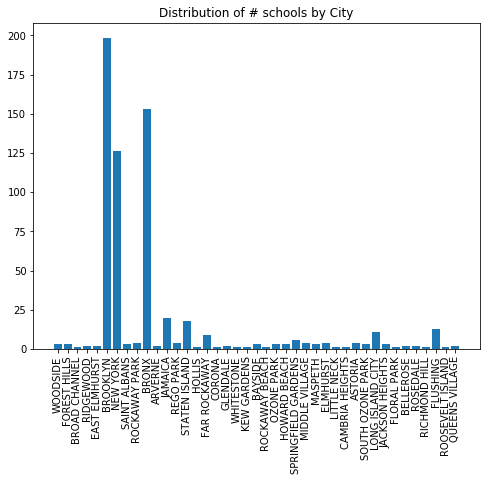

In [5]:
plot_city_hist(df_schools, 'Distribution of # schools by City')

### Attacking the absent ratio

The first and foremost aspect of the schools that we wish to address is the "chronically absent ratio" - if the number is too high for any given school - then the chances of improving that school, even by providing variety of resources would be very low. So, first we identify schools which have >40% of students being chronically absent. 

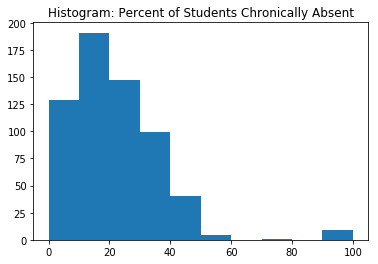

In [6]:
plt.figure(figsize = [6,4])
df_schools = df_schools.dropna(subset = ['Percent of Students Chronically Absent'])
plt.hist(df_schools['Percent of Students Chronically Absent'].values)
plt.title('Histogram: Percent of Students Chronically Absent')

In [7]:
chronically_absent_foi = ['School Name', 'Percent of Students Chronically Absent','Percent Black / Hispanic','Economic Need Index']

df_schools_ca = df_schools[df_schools['Percent of Students Chronically Absent'] > 40]
df_schools_nca = df_schools[df_schools['Percent of Students Chronically Absent'] < 40]

df_schools_ca[chronically_absent_foi].sort_values('Percent of Students Chronically Absent', ascending = False)

,School Name,Percent of Students Chronically Absent,Percent Black / Hispanic,Economic Need Index
1261,SUCCESS ACADEMY CHARTER SCHOOL - BRONX 2,100.0,98.0,0.794
1260,SUCCESS ACADEMY CHARTER SCHOOL - BRONX 1,100.0,96.0,0.825
1206,SUCCESS ACADEMY CHARTER SCHOOL - UPPER WEST,100.0,48.0,0.369
1203,SUCCESS ACADEMY CHARTER SCHOOL - HARLEM 5,100.0,95.0,0.789
1198,SUCCESS ACADEMY CHARTER SCHOOL - HARLEM 4,100.0,94.0,0.711
1197,SUCCESS ACADEMY CHARTER SCHOOL - HARLEM 3,100.0,94.0,0.720
1196,SUCCESS ACADEMY CHARTER SCHOOL - HARLEM 2,100.0,97.0,0.734
1173,BROOKLYN LAB CHARTER SCHOOL,100.0,89.0,0.639
1121,SUCCESS ACADEMY CHARTER SCHOOL - BED-STUY 1,100.0,96.0,0.750
300,NEW DIRECTIONS SECONDARY SCHOOL,74.0,98.0,0.920


In [8]:
print('%d schools have > 40%% students chronically absent'%(df_schools_ca.shape[0]))

49 schools have > 40% students chronically absent


### School performance Indicator

Next, we explore the 6 fields in the dataset which are indicative of the overall standing of the school. These features include:
* Rigorous Instruction %
* Collaborative Teachers %
* Supportive Environment %
* Effective School Leadership %
* Strong Family-Community Ties %
* Trust %

We show some typical values of these measures below

In [9]:
features_list = ['Rigorous Instruction %',
'Collaborative Teachers %',
'Supportive Environment %',
'Effective School Leadership %',
'Strong Family-Community Ties %',
'Trust %']

# for col in features_list:
#     df_schools[col] = df_schools[col].astype(np.object).str.replace('%', '').astype(float)

df_schools[['School Name'] + features_list ].head()

,School Name,Rigorous Instruction %,Collaborative Teachers %,Supportive Environment %,Effective School Leadership %,Strong Family-Community Ties %,Trust %
3,P.S. 034 FRANKLIN D. ROOSEVELT,85.0,78.0,82.0,73.0,89.0,88.0
8,P.S. 140 NATHAN STRAUS,94.0,91.0,85.0,87.0,83.0,93.0
10,P.S. 184M SHUANG WEN,90.0,81.0,91.0,67.0,83.0,85.0
11,P.S. 188 THE ISLAND SCHOOL,100.0,100.0,99.0,99.0,92.0,99.0
12,ORCHARD COLLEGIATE ACADEMY,72.0,77.0,77.0,72.0,76.0,87.0


In [10]:
df_schools[features_list].corr()

,Rigorous Instruction %,Collaborative Teachers %,Supportive Environment %,Effective School Leadership %,Strong Family-Community Ties %,Trust %
Rigorous Instruction %,1.000000,0.757568,0.720514,0.643093,0.540730,0.708931
Collaborative Teachers %,0.757568,1.000000,0.594114,0.915435,0.485351,0.882959
Supportive Environment %,0.720514,0.594114,1.000000,0.488354,0.581007,0.714141
Effective School Leadership %,0.643093,0.915435,0.488354,1.000000,0.444356,0.853213
Strong Family-Community Ties %,0.540730,0.485351,0.581007,0.444356,1.000000,0.588877
Trust %,0.708931,0.882959,0.714141,0.853213,0.588877,1.000000


In [11]:
features_list =  list(set(features_list) - set(['Collaborative Teachers %','Trust %']))

In [12]:
correlated_features_list = ["Effective School Leadership %","Collaborative Teachers %","Trust %"]
corr_features_values = df_schools[correlated_features_list].values

from sklearn.decomposition import PCA

pca = PCA(n_components=1)
combined_feature_value = pca.fit_transform(corr_features_values)
df_schools['PCA Combined Feature'] = combined_feature_value
df_schools[correlated_features_list + ['PCA Combined Feature']].corr()

,Effective School Leadership %,Collaborative Teachers %,Trust %,PCA Combined Feature
Effective School Leadership %,1.000000,0.915435,0.853213,-0.979714
Collaborative Teachers %,0.915435,1.000000,0.882959,-0.970069
Trust %,0.853213,0.882959,1.000000,-0.920314
PCA Combined Feature,-0.979714,-0.970069,-0.920314,1.000000


In [13]:
scaler = sklearn.preprocessing.MinMaxScaler()
scale_factor = 2*(df_schools['PCA Combined Feature'].corr(df_schools["Effective School Leadership %"])>0) -1 
df_schools['PCA Combined Feature'] =  scaler.fit_transform(scale_factor * df_schools['PCA Combined Feature'].values.reshape(-1,1))*100

In [14]:
df_schools[correlated_features_list + ['PCA Combined Feature']].corr()

,Effective School Leadership %,Collaborative Teachers %,Trust %,PCA Combined Feature
Effective School Leadership %,1.000000,0.915435,0.853213,0.979714
Collaborative Teachers %,0.915435,1.000000,0.882959,0.970069
Trust %,0.853213,0.882959,1.000000,0.920314
PCA Combined Feature,0.979714,0.970069,0.920314,1.000000


Weights to each factor

1.0 Supportive Environment % (Supportive Environment Rating) <br>
0.8 Rigorous Instruction % (Rigorous Instruction Rating) <br>
0.7 Effective School Leadership % (Effective School Leadership Rating) <br>
0.5 Strong Family-Community Ties % (Strong Family-Community Ties Rating)<br>

Collaborative Teachers % (Collaborative Teachers Rating) <br>
Trust % (Trust Rating)<br>

In [15]:
features = ['Rigorous Instruction %','Supportive Environment %','PCA Combined Feature',
            'Strong Family-Community Ties %']
weights = [0.8, 1, 0.7, 0.5]

df_schools['SPI'] = df_schools[features].dot(weights)

df_schools[features+['SPI']].head(5)

,Rigorous Instruction %,Supportive Environment %,PCA Combined Feature,Strong Family-Community Ties %,SPI
3,85.0,82.0,78.859046,89.0,249.701332
8,94.0,85.0,90.408101,83.0,264.985671
10,90.0,91.0,76.608591,83.0,258.126014
11,100.0,99.0,100.000000,92.0,295.000000
12,72.0,77.0,77.852373,76.0,227.096661


In [16]:
df_low_spi_schools = df_schools[df_schools['SPI'] < df_schools['SPI'].quantile(.25)]
df_high_spi_schools = df_schools[df_schools['SPI'] > df_schools['SPI'].quantile(.25)]

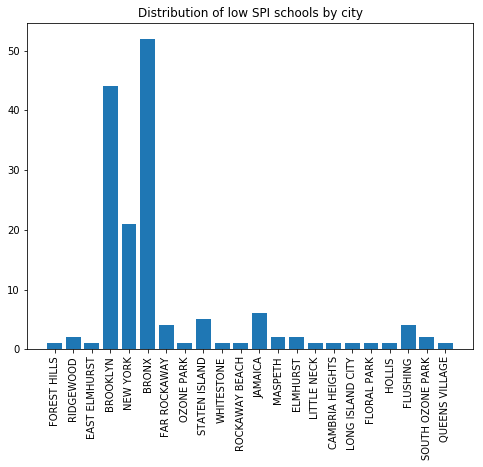

In [17]:
plot_city_hist(df_low_spi_schools, 'Distribution of low SPI schools by city')

In [18]:
df_low_spi_schools[['Average ELA Proficiency','Average Math Proficiency']].mean()

Average ELA Proficiency     2.366839
Average Math Proficiency    2.370323
dtype: float64

In [19]:
df_high_spi_schools[['Average ELA Proficiency','Average Math Proficiency']].mean()

Average ELA Proficiency     2.592795
Average Math Proficiency    2.703537
dtype: float64

### Economic Need Index

Defined as : %temp housing) + (% HRA eligible *0.5) + (% free lunch eligible *0.5). The higher the index, the higher the need

(array([  5.,  13.,  30.,  31.,  41.,  54.,  61., 135., 146., 104.]),
 array([0.059 , 0.1469, 0.2348, 0.3227, 0.4106, 0.4985, 0.5864, 0.6743,
        0.7622, 0.8501, 0.938 ]),
 <a list of 10 Patch objects>)

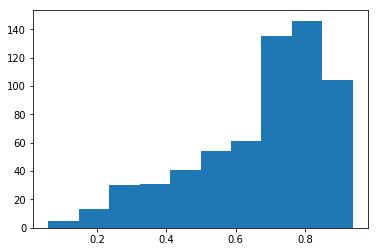

In [20]:
plt.hist(df_schools[['Economic Need Index']].values)

In [21]:
lower_bound = df_schools['Economic Need Index'].quantile(0.75)
df_schools_high_eni = df_schools[df_schools['Economic Need Index'] > lower_bound]
df_schools_low_eni = df_schools[df_schools['Economic Need Index'] < 0.25]

In [22]:
df_schools_high_eni[['School Name', 'Economic Need Index', 'Percent Black / Hispanic']].sort_values('Economic Need Index', ascending = False)

,School Name,Economic Need Index,Percent Black / Hispanic
298,NEW MILLENNIUM BUSINESS ACADEMY MIDDLE SCHOOL,0.938,98.0
283,I.S. 219 NEW VENTURE SCHOOL,0.929,98.0
1247,MOTT HAVEN ACADEMY CHARTER SCHOOL,0.928,98.0
762,BROWNSVILLE COLLABORATIVE MIDDLE SCHOOL,0.925,96.0
300,NEW DIRECTIONS SECONDARY SCHOOL,0.920,98.0
346,"P.S. 279 CAPTAIN MANUEL RIVERA, JR.",0.918,96.0
11,P.S. 188 THE ISLAND SCHOOL,0.917,93.0
299,I.S. 339,0.913,98.0
714,P.S. 288 THE SHIRLEY TANYHILL,0.912,90.0
363,M.S. 390,0.911,98.0


In [23]:
df_schools_high_eni[['Average ELA Proficiency','Average Math Proficiency']].mean()

Average ELA Proficiency     2.247792
Average Math Proficiency    2.261688
dtype: float64

In [24]:
df_schools_low_eni[['Average ELA Proficiency','Average Math Proficiency']].mean()

Average ELA Proficiency     3.267917
Average Math Proficiency    3.422083
dtype: float64

### Filtering out schools where most of the students are black / hispanic and their 4s scores are low

In [25]:
def find_schools_with_black_high_4s_low(df, grade = 5, black_per_threshold = 90, all_students_threshold = 5):
    math_black_students = "Grade {} Math 4s - Black or African American".format(grade)
    math_hispanic_students = "Grade {} Math 4s - Hispanic or Latino".format(grade)
    math_all_students = "Grade {} Math 4s - All Students".format(grade)
    
    df_schools = df.copy()
    
    df_schools['4s ratio black / hispanic'] = (df_schools[math_black_students] + df_schools[math_hispanic_students])/ df_schools[math_all_students]
    df_schools_black_4s = df_schools[np.logical_and(df_schools['Percent Black / Hispanic'] > black_per_threshold, df_schools[math_all_students] > all_students_threshold)]
    df_schools_black_4s.dropna(inplace=True)
    
    #print "The following are the various statistics related to 4s score : \n"
    #print df_schools_black_4s['4s ratio black / hispanic'].describe()
    
    #plt.figure(figsize=[6,4])
    #df_schools_black_4s['4s ratio black / hispanic'].hist()
    #plt.title("Histogram : Percent of 4s scores of black/hispanic students in grade {}".format(grade))
    
    df_schools_black_4s_low = df_schools_black_4s[df_schools_black_4s['4s ratio black / hispanic'] < 0.5]
    num_schools = len(df_schools_black_4s_low)                      
    #print "\n Number of schools which have poor performing black/ hispanic students in grade {} : {} \n".format(grade, num_schools)
    
    #print df_schools_black_4s_low[['School Name', 'City', math_hispanic_students, math_black_students, math_all_students]]
    return df_schools_black_4s_low

In [26]:
schools_with_black_high_4s_low = []

In [27]:
for grade in xrange(5,9):
    df_schools_with_black_high_4s_low = find_schools_with_black_high_4s_low(df_schools, grade=grade)
    schools_with_black_high_4s_low.extend(np.unique(df_schools_with_black_high_4s_low['School Name']))

schools_with_black_high_4s_low = list(set(schools_with_black_high_4s_low))

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [28]:
schools_with_black_high_4s_low

['P.S. 108 ASSEMBLYMAN ANGELO DEL TORO EDUCATIONAL COMPLEX',
 'ICAHN CHARTER SCHOOL',
 'ICAHN CHARTER SCHOOL 4',
 'HARLEM VILLAGE ACADEMY LEADERSHIP CHARTER SCHOOL',
 'WASHINGTON HEIGHTS ACADEMY',
 'HARLEM PREP CHARTER SCHOOL',
 'P.S. 129 JOHN H. FINLEY',
 'BUSHWICK ASCEND CHARTER SCHOOL',
 'P.S. 235 JANICE MARIE KNIGHT SCHOOL',
 'BRONX ACADEMY OF PROMISE CHARTER SCHOOL',
 'THE GORDON PARKS SCHOOL',
 'SUCCESS ACADEMY CHARTER SCHOOL - BRONX 2',
 'ACHIEVEMENT FIRST EAST NEW YORK CHARTER SCHOOL',
 'ACHIEVEMENT FIRST CROWN HEIGHTS CHARTER SCHOOL',
 'BRONX CHARTER SCHOOL FOR THE ARTS']

In [29]:
df_filtered_schools = df_schools[df_schools['School Name'].isin(schools_with_black_high_4s_low)]
df_filtered_schools[['School Name', 'City', 'Economic Need Index', 'SPI']]

,School Name,City,Economic Need Index,SPI
116,P.S. 108 ASSEMBLYMAN ANGELO DEL TORO EDUCATION...,NEW YORK,0.843,250.659931
137,P.S. 129 JOHN H. FINLEY,NEW YORK,0.854,253.848145
189,WASHINGTON HEIGHTS ACADEMY,NEW YORK,0.777,273.752232
601,P.S. 235 JANICE MARIE KNIGHT SCHOOL,BROOKLYN,0.520,265.985192
990,THE GORDON PARKS SCHOOL,ROSEDALE,0.358,255.315343
1116,ACHIEVEMENT FIRST CROWN HEIGHTS CHARTER SCHOOL,BROOKLYN,0.570,247.994694
1118,ACHIEVEMENT FIRST EAST NEW YORK CHARTER SCHOOL,BROOKLYN,0.693,265.012899
1171,BUSHWICK ASCEND CHARTER SCHOOL,BROOKLYN,0.760,243.979200
1189,HARLEM VILLAGE ACADEMY LEADERSHIP CHARTER SCHOOL,NEW YORK,0.722,249.109716
1210,HARLEM PREP CHARTER SCHOOL,NEW YORK,0.815,258.132590


In [30]:
school_map = folium.Map([df_filtered_schools['Latitude'].mean(), df_filtered_schools['Longitude'].mean()], 
                        zoom_start=11,
                        tiles='Stamen Terrain')

for index in df_filtered_schools.index:
    row = df_filtered_schools.loc[index]
    school_name = str(row['School Name'])
    
    color = 'blue'
    folium.Marker([row['Latitude'], row['Longitude']], popup=school_name, icon=folium.Icon(color=color)).add_to(school_map)

school_map

### Crime

In [46]:
df_crime = pd.read_csv('../../../input/2010-2016-school-safety-report.csv')

intersection = set(df_crime['DBN']).intersection(set(df_schools['Location Code']))
print('%d schools found in the supplementary dataset out of %d in original dataset')%(len(intersection), len(df_schools))

crimes_col = ['Major N', 'Oth N', 'NoCrim N', 'Prop N', 'Vio N']
crimes = df_crime.groupby(['DBN'], as_index=False)[crimes_col].sum()

merged_safety_df = pd.merge(crimes[crimes_col + ['DBN']], df_schools, how='inner', left_on=['DBN'], right_on=['Location Code'])
merged_safety_df.dropna(subset=crimes_col, inplace=True,how='all')

541 schools found in the supplementary dataset out of 620 in original dataset


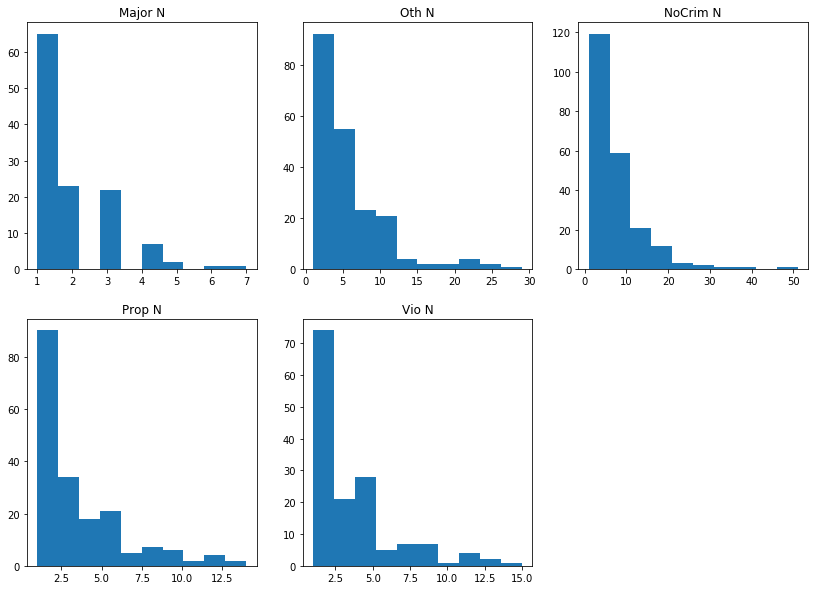

In [47]:
def plot_crime_histogram(column_name, i):
    plt.subplot(2,3,i+1)
    plt.hist(merged_safety_df[column_name][merged_safety_df[column_name]!=0])
    plt.title(column_name)
    
plt.figure(figsize = [14,10])    
for i,column_name in enumerate(crimes_col):
    plot_crime_histogram(column_name, i)

In [78]:
violent_df = merged_safety_df[merged_safety_df['Vio N'] > 4]
print len(violent_df)
major_crime_df = merged_safety_df[merged_safety_df['Major N'] > 2]
print len(major_crime_df)

43
33


In [53]:
crimes[crimes_col].corr()

,Major N,Oth N,NoCrim N,Prop N,Vio N
Major N,1.000000,0.708126,0.637933,0.776863,0.742657
Oth N,0.708126,1.000000,0.850111,0.920975,0.875546
NoCrim N,0.637933,0.850111,1.000000,0.751986,0.774343
Prop N,0.776863,0.920975,0.751986,1.000000,0.707398
Vio N,0.742657,0.875546,0.774343,0.707398,1.000000


In [56]:
features_pca = merged_safety_df[crimes_col].values

from sklearn.decomposition import PCA

school_crime_pca = PCA(n_components=1)
school_crime_pca.fit(features_pca)
reduced_crime_features = school_crime_pca.transform(features_pca)
print school_crime_pca.explained_variance_ratio_

[0.84379327]


In [71]:
import sklearn
scaler = sklearn.preprocessing.MinMaxScaler()
adjusted_reduced_crime_features = scaler.fit_transform(reduced_crime_features)

merged_safety_df['SRI'] = adjusted_reduced_crime_features

print('Correlation of risk measure with different features: ')
print('School Performance Index: '  + str(merged_safety_df['SRI'].corr(merged_safety_df['SPI'])))
print('Percent of Students Chronically Absent: '  + str(merged_safety_df['SRI'].corr(merged_safety_df['Percent of Students Chronically Absent'])))

Correlation of risk measure with different features: 
School Performance Index: -0.46190425176062133
Percent of Students Chronically Absent: 0.3555648074935336


In [76]:
risky_schools_df = merged_safety_df[merged_safety_df['SRI']>merged_safety_df['SRI'].quantile(0.9)]
risky_schools_df.shape[0]

26

<b> Schools with high SSI are marked as risky

In [77]:
risky_schools_df

,Major N,Oth N,NoCrim N,Prop N,Vio N,DBN,School Name,SED Code,Location Code,District,...,Grade 8 Math 4s - Hispanic or Latino,Grade 8 Math 4s - Asian or Pacific Islander,Grade 8 Math 4s - White,Grade 8 Math 4s - Multiracial,Grade 8 Math 4s - Limited English Proficient,Grade 8 Math 4s - Economically Disadvantaged,PCA Combined Feature,SPI,SSI,SRI
31,4.0,14.0,32.0,10.0,7.0,02M655,LIFE SCIENCES SECONDARY SCHOOL,310200011655,02M655,2,...,0,0,0,0,0,0,78.683200,236.578240,0.673239,0.673239
75,3.0,21.0,25.0,12.0,10.0,05M499,FREDERICK DOUGLASS ACADEMY,310500011499,05M499,5,...,0,0,0,0,0,3,81.683807,246.378665,0.672450,0.672450
77,3.0,11.0,11.0,11.0,3.0,05M670,THURGOOD MARSHALL ACADEMY FOR LEARNING AND SOC...,310500011670,05M670,5,...,0,0,0,0,0,0,87.467322,240.427126,0.337783,0.337783
116,5.0,15.0,14.0,9.0,9.0,08X269,BRONX STUDIO SCHOOL FOR WRITERS AND ARTISTS,320800011269,08X269,8,...,1,0,0,0,0,0,85.430927,241.101649,0.444000,0.444000
139,3.0,13.0,14.0,3.0,7.0,09X231,EAGLE ACADEMY FOR YOUNG MEN,320900011231,09X231,9,...,0,0,0,0,0,0,86.042011,245.329408,0.380118,0.380118
154,3.0,11.0,16.0,6.0,3.0,09X505,"BRONX SCHOOL FOR LAW, GOVERNMENT AND JUSTICE",320900011505,09X505,9,...,3,0,0,0,0,4,80.069689,237.148782,0.381362,0.381362
160,1.0,9.0,19.0,2.0,7.0,10X045,THOMAS C. GIORDANO MIDDLE SCHOOL 45,321000010045,10X045,10,...,0,0,0,0,0,0,82.418795,245.793157,0.399587,0.399587
164,7.0,19.0,51.0,8.0,11.0,10X118,J.H.S. 118 WILLIAM W. NILES,321000010118,10X118,10,...,17,14,3,0,0,38,76.491138,238.243796,1.000000,1.000000
165,0.0,10.0,22.0,5.0,3.0,10X141,RIVERDALE / KINGSBRIDGE ACADEMY (MIDDLE SCHOOL...,321000011141,10X141,10,...,5,2,6,0,0,6,80.231807,242.862265,0.443388,0.443388
192,2.0,22.0,13.0,12.0,8.0,11X181,I.S. 181 PABLO CASALS,321100010181,11X181,11,...,4,12,0,0,0,26,88.311877,255.918314,0.506303,0.506303


### Teacher to student ratio

In [83]:
df_school_detail = pd.read_csv('../../../input/2010-2011-class-size-school-level-detail.csv')
df_school_detail["CSD"] =  df_school_detail['CSD'].astype('str').astype(np.object_).str.zfill(2)
df_school_detail["DBN_manual"] = df_school_detail["CSD"] + df_school_detail["SCHOOL CODE"] 
df_school_detail.dropna(subset=['SCHOOLWIDE PUPIL-TEACHER RATIO'], inplace=True)
dbn_intersection = list((set(df_school_detail['DBN_manual'])).intersection(set(df_schools["Location Code"])))

In [84]:
len(dbn_intersection)

470

470